In [235]:
import numpy as np

In [236]:
class ClusteringFeature:
	def __init__(self, data_dimensionality):
		self.N = 0
		self.LS = np.zeros(data_dimensionality)
		self.SS = 0

	def add_point(self, x):
		self.N += 1
		self.LS += np.array(x)
		self.SS += np.dot(x, x)

	def merge(self, other):
		self.N += other.N
		self.LS += other.LS
		self.SS += other.SS

	def centroid(self):
		if self.N == 0:
			return np.zeros_like(self.LS)
		return self.LS / self.N

	def radius(self):
		centroid = self.centroid()
		variance = (self.SS / self.N) - np.dot(centroid, centroid)
		variance = max(variance, 0) # evita numeri negativi per arrotondamenti
		return np.sqrt(variance)
		# return np.sqrt((self.SS / self.N) - np.sum(self.centroid() ** 2))

	def diameter(self):
		if self.N <= 1:
			return 0.0
		numerator = 2 * self.N * np.sum(self.SS) - 2 * np.dot(self.LS, self.LS)
		denominator = self.N * (self.N - 1)
		diameter_sq = numerator / denominator
		return np.sqrt(diameter_sq)

	def __repr__(self):
		return f"ClusteringFeature(N={self.N}, LS={self.LS}, SS={self.SS:.4f})"


In [237]:
class CFNode:
	def __init__(self, branching_factor, threshold, data_dimensionality, is_leaf):
		self.branching_factor = branching_factor
		self.threshold = threshold
		self.is_leaf = is_leaf
		self.data_dimensionality = data_dimensionality

		self.parent = None # È il CFNode padre del nodo corrente
		self.CF_list = []  # Lista di ClusteringFeature
		self.children_list = [] # Lista di CFNode figli del nodo corrente

		if self.is_leaf:
			self.next_leaf = None  # puntatore alla foglia successiva
			self.prev_leaf = None  # puntatore alla foglia precedente

	def find_closest_CF(self, cf):
		min_dist = float('inf')
		closest = None
		for entry in self.CF_list:
			dist = np.linalg.norm(entry.centroid() - cf.centroid())
			if dist < min_dist:
				min_dist = dist
				closest = entry
		return closest

	def insert_CF(self, cf):
		# 'closest_cf' è un CF, il più vicino al CF passato in input
		closest_cf = self.find_closest_CF(cf)
		#print("current CF:", self.CF_list)
		#print("to add:", cf)
		#print("closest:", closest_cf)

		# Se nodo leaf
		if self.is_leaf:
			# Se non ci sono ancora CF nel nodo leaf
			if not self.CF_list:
				self.CF_list.append(cf)
				return None
			
			# Provo a vedere se il più vicino e quello in input < T
			temp_cf = ClusteringFeature(self.data_dimensionality)
			temp_cf.merge(closest_cf)
			temp_cf.merge(cf)
			
			if temp_cf.radius() < self.threshold:
				# Se si, we are good to go, aggiungo e basta
				closest_cf.merge(cf) 
				#print("assorbibile")
			else:
				# Altrimenti aggiungo il CF al nodo
				self.CF_list.append(cf)
				#print("non assorbibile")
				# Ma se il nodo ha raggiunto il numero massimo di CF, ovvero B, devo splittare 
				if len(self.CF_list) > self.branching_factor:
					return self.split()
		# Se il nodo non è foglia
		else:
			# Mi trovo l'indice del CF più vicino a quello dato in input
			idx = self.CF_list.index(closest_cf)
			# Attraverso l'indice trovo il nodo figlio (che è un CFNode)
			child = self.children_list[idx]

			# Inserisco il CF nel figlio, aka chiamo ricorsivamente questo metodo
			new_root = child.insert_CF(cf)

			if new_root:
				return new_root

			# aggiorna il CF di questo nodo che rappresenta il figlio
			# ricostruendo o aggiornando il CF
			self.CF_list[idx] = self.children_list[idx].compute_cumulative_CF()

			# controllo overflow del nodo
			if len(self.CF_list) > self.branching_factor:
				return self.split()
		return None

	def compute_cumulative_CF(self):
		cf = ClusteringFeature(self.data_dimensionality)
		for entry in self.CF_list:
			cf.merge(entry)
		return cf
			
	def split(self):
		# Step 1: trova i due CF più lontani
		max_dist = -1
		seed1, seed2 = None, None
		for i in range(len(self.CF_list)):
			for j in range(i + 1, len(self.CF_list)):
				dist = np.linalg.norm(self.CF_list[i].centroid() - self.CF_list[j].centroid())
				if dist > max_dist:
					max_dist = dist
					seed1, seed2 = self.CF_list[i], self.CF_list[j] # seed1 e seed2 sono due CF

		# Step 2: crea due nuovi nodi
		new_node1 = CFNode(
			data_dimensionality = self.data_dimensionality,
			branching_factor = self.branching_factor,
			threshold = self.threshold,
			is_leaf = self.is_leaf # Se il nodo corrente è foglia, allora lo saranno anche i due nuovi e idem nel caso non-foglia
		)
		new_node2 = CFNode(
			data_dimensionality = self.data_dimensionality,
			branching_factor = self.branching_factor,
			threshold = self.threshold,
			is_leaf = self.is_leaf
		)

		# Aggiungo ai due nodi i CF più lontani appena trovati
		new_node1.CF_list.append(seed1)
		new_node2.CF_list.append(seed2)

		new_node1.parent = self.parent
		new_node2.parent = self.parent

		# Se il nodo non è una foglia allora devo 
		if not self.is_leaf:
			idx_seed1 = self.CF_list.index(seed1)
			idx_seed2 = self.CF_list.index(seed2)
			# Aggiungere alla lista dei figli dei nuovi nodi i figli che appartenevano al nodo prima
			new_node1.children_list.append(self.children_list[idx_seed1])
			# Il figlio deve sapere chi è il suo parent
			new_node1.children_list[0].parent = new_node1
			new_node2.children_list.append(self.children_list[idx_seed2])
			new_node2.children_list[0].parent = new_node2

		# Riassegna gli altri CF al nodo più vicino
		for idx, cf in enumerate(self.CF_list): # Scorro sulla lista di CF del nodo da splittare
			if cf in (seed1, seed2): # Questi sono già stati assegnati e quindi li ignoro
				continue

			# Per ogni CF nella lista calcolo la distanza tra centroidi di entrambi i nuovi nodi 
			dist1 = np.linalg.norm(cf.centroid() - new_node1.CF_list[0].centroid())
			dist2 = np.linalg.norm(cf.centroid() - new_node2.CF_list[0].centroid())

			if dist1 < dist2: 
				#print("primo più vicino", dist1, dist2)
				new_node1.CF_list.append(cf) # Se più vicino al new_node1, allora aggiungo il CF corrente alla lista del nodo 1
				if not self.is_leaf:
					new_node1.children_list.append(self.children_list[idx])
					new_node1.children_list[-1].parent = new_node1 # Insegna all'utlimo elemento appena aggiunto chi è suo padre
			else:
				#print("secondo più vicino", dist1, dist2)
				new_node2.CF_list.append(cf) # Altrimenti appendo all'altro nodo
				if not self.is_leaf:
					new_node2.children_list.append(self.children_list[idx])
					new_node2.children_list[-1].parent = new_node2

		# Se il nodo splittato aveva un parent, quindi sempre a meno che non sono sulla root
		if self.parent:
			# Rimuovo il riferimento a questo nodo nel parent
			parent = self.parent
			# Trovo indice del nodo corrente nel parent
			idx_in_parent = parent.children_list.index(self)

			# Rimuovo l'attuale nodo e il suo CF entry
			parent.children_list.pop(idx_in_parent)
			parent.CF_list.pop(idx_in_parent)

			# Inserisco i due nuovi nodi
			parent.CF_list.append(new_node2.compute_cumulative_CF() if not new_node2.is_leaf else new_node2.CF_list[0])
			parent.children_list.append(new_node2)

			parent.CF_list.append(new_node1.compute_cumulative_CF() if not new_node1.is_leaf else new_node1.CF_list[0])
			parent.children_list.append(new_node1)

			# Controllo overflow del parent
			if len(parent.CF_list) > parent.branching_factor:
				return parent.split()
			else:
				return None
		# Altrimenti se ho splittato la root
		else:
			# Creo il nuovo nodo root
			new_root = CFNode(
				branching_factor=self.branching_factor,
				threshold=self.threshold,
				data_dimensionality=self.data_dimensionality,
				is_leaf=False
			)
			new_node1.parent = new_root
			new_node2.parent = new_root
			new_root.children_list = [new_node1, new_node2]
			new_root.CF_list = [
				new_node1.compute_cumulative_CF() if not new_node1.is_leaf else new_node1.CF_list[0],
				new_node2.compute_cumulative_CF() if not new_node2.is_leaf else new_node2.CF_list[0]
			]
			return new_root

	def __repr__(self):
		tipo = "Leaf" if self.is_leaf else "Non-leaf"
		return f"CFNode({tipo}, num_CF={len(self.CF_list)})"


In [238]:
class CFTree:
	def __init__(self, branching_factor, threshold, data_dimensionality):
		self.branching_factor = branching_factor
		self.threshold = threshold
		self.data_dimensionality = data_dimensionality
		# Un albero viene creato con la sua radice, la radice è un nodo, i nodi contengono (al più branching_factor) ClusteringFeature
		self.root = CFNode(self.branching_factor, self.threshold, self.data_dimensionality, is_leaf=True)
	
	def insert_datapoint(self, point):
		# Creo il CF 
		cf = ClusteringFeature(self.data_dimensionality)
		cf.add_point(point)

		# Lo inserisco nell'albero
		split_result = self.root.insert_CF(cf)

		if split_result:
			self.root = split_result

	def get_leaf_CFs(self):
		leaves = []
		queue = [self.root]
		while queue:
			node = queue.pop(0)
			if node.is_leaf:
				leaves.extend(node.CF_list)
			else:
				queue.extend(node.children_list)

		return leaves
	

In [239]:
def test_cftree_basic(branching_factor, threshold, data_dimensionality):

	tree = CFTree(branching_factor, threshold, data_dimensionality)
	
	points = [
		np.array([3, 4]),
		np.array([2, 6]),
		np.array([4, 5]),
		np.array([4, 7]),
		np.array([3, 8]),
		np.array([6, 2]),
		np.array([7, 2]),
		np.array([7, 4]),
		np.array([8, 4]),
		np.array([7, 9])
	]

	for idx, p in enumerate(points):
		print(f"\n>>> Inserisco punto {idx+1}: {p}")
		tree.insert_datapoint(p)
		print_tree(tree.root)
		
	leaves = tree.get_leaf_CFs()
	print("\nCentroidi finali dei CF nelle foglie:")
	for cf in leaves:
		print(cf)

def print_tree(node, level=0):
	indent = "  " * level
	print(f"{indent}{node}")
	if not node.is_leaf:
		for child in node.children_list:
			print_tree(child, level+1)

if __name__ == "__main__":
	test_cftree_basic(3, 1, 2)



>>> Inserisco punto 1: [3 4]
CFNode(Leaf, num_CF=1)

>>> Inserisco punto 2: [2 6]
CFNode(Leaf, num_CF=2)

>>> Inserisco punto 3: [4 5]
CFNode(Leaf, num_CF=2)

>>> Inserisco punto 4: [4 7]
CFNode(Leaf, num_CF=3)

>>> Inserisco punto 5: [3 8]
CFNode(Leaf, num_CF=3)

>>> Inserisco punto 6: [6 2]
CFNode(Non-leaf, num_CF=2)
  CFNode(Leaf, num_CF=3)
  CFNode(Leaf, num_CF=1)

>>> Inserisco punto 7: [7 2]
CFNode(Non-leaf, num_CF=2)
  CFNode(Leaf, num_CF=3)
  CFNode(Leaf, num_CF=1)

>>> Inserisco punto 8: [7 4]
CFNode(Non-leaf, num_CF=2)
  CFNode(Leaf, num_CF=3)
  CFNode(Leaf, num_CF=2)

>>> Inserisco punto 9: [8 4]
CFNode(Non-leaf, num_CF=2)
  CFNode(Leaf, num_CF=3)
  CFNode(Leaf, num_CF=2)

>>> Inserisco punto 10: [7 9]
CFNode(Non-leaf, num_CF=3)
  CFNode(Leaf, num_CF=2)
  CFNode(Leaf, num_CF=1)
  CFNode(Leaf, num_CF=3)

Centroidi finali dei CF nelle foglie:
ClusteringFeature(N=2, LS=[13.  4.], SS=93.0000)
ClusteringFeature(N=2, LS=[15.  8.], SS=145.0000)
ClusteringFeature(N=1, LS=[7. 9.], S

Dataset totale: 105000 punti


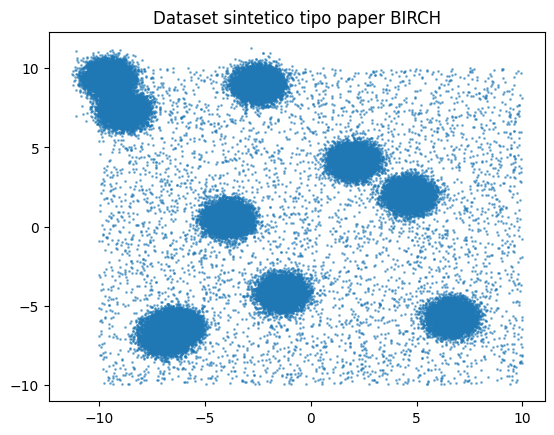

In [240]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

# Generiamo dataset
X, y = make_blobs(n_samples=100000, centers=10, cluster_std=0.5, random_state=42)

# Aggiungiamo un po' di noise
noise = np.random.uniform(low=-10, high=10, size=(5000, 2))
X = np.vstack([X, noise])

print(f"Dataset totale: {X.shape[0]} punti")

# Visualizziamo
plt.scatter(X[:,0], X[:,1], s=1, alpha=0.5)
plt.title("Dataset sintetico tipo paper BIRCH")
plt.show()


In [257]:
tree2 = CFTree(branching_factor=10, threshold=1.5, data_dimensionality=2)

for idx, p in enumerate(X):
		#print(f"\n>>> Inserisco punto {idx+1}: {p}")
		tree2.insert_datapoint(p)
		#print_tree(tree2.root)
		
leaves = tree2.get_leaf_CFs()
#print("\nCentroidi finali dei CF nelle foglie:")
#for cf in leaves:
	#print(cf)


In [258]:
centroids = np.array([cf.centroid() for cf in leaves])
len(centroids)

8

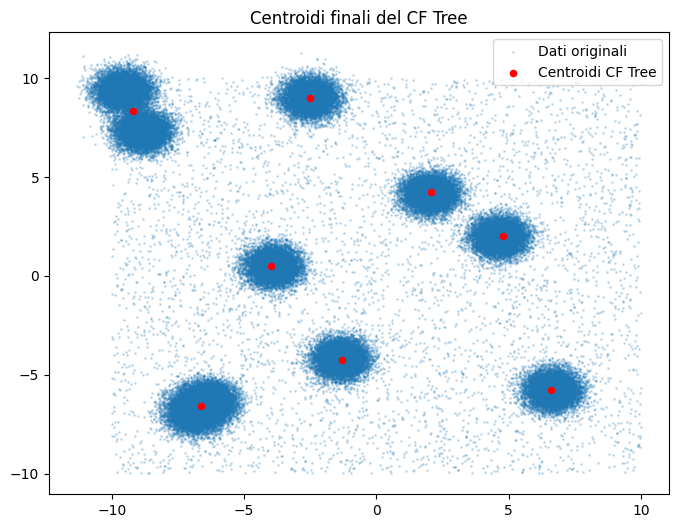

In [259]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], s=1, alpha=0.2, label='Dati originali')
plt.scatter(centroids[:,0], centroids[:,1], color='red', s=20, label='Centroidi CF Tree')
plt.legend()
plt.title("Centroidi finali del CF Tree")
plt.show()
